In [51]:
#Importing necessary libraries
import os
import pickle
import platform
import random
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

In [52]:
#Loading the pickle file and preventing UnicodeDecodeError.
#seems os.path.join allows subdirectory to be accessed. Python doesnt have any automatic path expander
def load_pickle(f):
    #Checks if my version of python is python 2
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    #Checks if my version of python is python 3
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        #Reshaping the data and arranging the axis of data--> expect (10000, 32, 32, 3)
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

In [53]:
def get_CIFAR10_data(
    num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = os.path.join(
        "C:/Users/DELL  LATITUDE E5480/Downloads/Neural networks/cifar-10-batches-py"
    )
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

In [54]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
print(data.keys())
for k, v in list(data.items()):
    print(('%s: ' % k, v.shape))

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test'])
('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [63]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)
      I think they are referring to M as number of nodes in the current layer
      D number of nodes in the prev layer(input features)
      The weight matrix is in that shape inorder to make the dot product with x work out
    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    x_reshaped = x.reshape(x.shape[0], -1)
    out = x_reshaped.dot(w) + b
    #Stored these to calculate the gradients of each weight and bias during backpropagation
    cache = (x, w, b)
    return out, cache

def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    x_reshape = x.reshape(x.shape[0], -1)
    dx = dout.dot(w.T).reshape(x.shape[0], *x.shape[1:])
    dw = x_reshape.T.dot(dout)
    db = dout.sum(axis=0)
    return dx, dw, db

def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    
    out = np.maximum(0, x)

    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    
    #dx = dout * (x>0)
    #np.sign return -1 for x < 0, 0 for x = 0 and 1 for x>0
    dx = dout * np.maximum(0, np.sign(x))

    return dx

def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

In [56]:
def rel_error(x, y):
    """ returns relative error """
    return np.mean(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


In [1]:
import numpy as np
2 * np.prod((4,5,6))

240

In [57]:
# Test the affine_forward function
#Creating our own fake image data
#Two input examples
num_inputs = 2
input_shape = (4, 5, 6)#shape of the input matrix ( doesnt look so much like that of an image)
output_dim = 3 #This is the number outputs(number of neurons in the current layer.We can often choose this)

#Gives the number of examples and features to make two exampes of dimensions (4,5,6) each
input_size = num_inputs * np.prod(input_shape)#np.prod() multiplies every thing in a matrix depending on the axis specifed
#Multiplied by number of inputs above get data for n_inputs. In this case 2 inputs
weight_size = output_dim * np.prod(input_shape)

#Generates 2 examples of 120(4*5*6) features each
x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)#N*4*5*6
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)#D*M
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Crosschecking the outputs. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  4.4980213267927333e-10


In [58]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    Used for computing the gradient for all elements in an input array
    """
    grad = np.zeros_like(x)#Pass in an array and it returns the same array shape but filled with zeros
    #Iterating over every element of x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    #it.finished returns a boolean which becomes true when the multidimensional index is (n-1, n-1)
    while not it.finished:
        #Generates a multi dimensional index to access the array
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

In [59]:
#an "affine layer" refers to a type of layer that performs an affine transformation on the input data.
#The term "affine" is borrowed from linear algebra and represents a linear mapping followed by an addition of a bias term.
# Test the affine_backward function
#Affine means some sort of linear transformation
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

#Derivatives of the loss function with respect to the input matrix s, the weights and the bias
dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  7.014061714324505e-12
dw error:  1.0939342930849144e-11
db error:  7.250396292811179e-12


## ReluActivation Forward

In [61]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  6.108465407644179e-09


## ReLU Activation:Backward

In [62]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  5.992932638723405e-13


In [64]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  9.248331790672996e-12
dw error:  7.29480399039121e-12
db error:  2.4480092782097138e-12


In [65]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  9.248331790672996e-12
dw error:  7.29480399039121e-12
db error:  2.4480092782097138e-12


## loss layers: Softmax and svm

In [67]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

In [73]:
def svm_loss(x, y):
    """
    Computes the loss and gradient using for multiclass SVM classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
    N = len(y)                                # number of samples
    x_true = x[range(N), y][:, None]          # scores for true labels
    margins = np.maximum(0, x - x_true + 1)   # margin for each score
    loss = margins.sum() / N - 1
    dx = (margins > 0).astype(float) / N
    dx[range(N), y] -= dx.sum(axis=1)

    return loss, dx

def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None
   
    N = len(y) # number of samples

    P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents
    P /= P.sum(axis=1, keepdims=True)            # row-wise probabilities (softmax)

    loss = -np.log(P[range(N), y]).sum() / N # sum cross entropies as loss

    P[range(N), y] -= 1
    dx = P / N
    
    return loss, dx

In [74]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.187715206266285e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  2.1402092523754495e-09


In [106]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(
        self,
        input_dim=3 * 32 * 32,
        hidden_dim=100,
        num_classes=10,
        weight_scale=1e-3,
        reg=0.0,
    ):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        # Initialized the weights and biases of the two-layer net. 
        # Weights was initialized from a Gaussian centered at 0.0 with               
        # standard deviation equal to weight_scale, and was           
        # initialized to zero. All weights and biases are stored in the      
        # dictionary self.params, with first layer weights                         
        # and biases using the keys 'W1' and 'b1' and second layer                 
        # weights and biases using the keys 'W2' and 'b2'.                         

        self.params = {
          'W1': np.random.randn(input_dim, hidden_dim) * weight_scale,
          'b1': np.zeros(hidden_dim),
          'W2': np.random.randn(hidden_dim, num_classes) * weight_scale,
          'b2': np.zeros(num_classes)
        }

    def loss(self, X, y=None):
        """
        Computes the loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None

        W1, b1, W2, b2 = self.params.values()

        out1, cache1 = affine_forward(X, W1, b1)
        out2, cache2 = relu_forward(out1)
        scores, cache3 = affine_forward(out2, W2, b2)

        # If y is None then we are in the test mode so just return scores
        #This means we are not calculating any loss or gradient
        if y is None:
            return scores

        loss, grads = 0, {}
        
        loss, dloss = softmax_loss(scores, y)
        #L2 regularization step
        loss += 0.5 * self.reg * (np.sum(W1**2) + np.sum(W2**2))

        dout3, dW2, db2 = affine_backward(dloss, cache3)
        dout2 = relu_backward(dout3, cache2)
        dout1, dW1, db1 = affine_backward(dout2, cache1)

        dW1 += self.reg * W1
        dW2 += self.reg * W2

        grads = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

        return loss, grads


In [77]:
#Two Layer Network
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.73e-09
W2 relative error: 1.19e-10
b1 relative error: 1.90e-09
b2 relative error: 1.02e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 3.82e-09
W2 relative error: 2.64e-10
b1 relative error: 1.09e-09
b2 relative error: 4.98e-10


In [84]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    #Returns the value of the key specified
    #In this case it assigns 1e-2 to key "learning_rate"
    #in the dictionary config and returns the value.
    config.setdefault("learning_rate", 1e-2)
    #This is the stochatic gradient descent step
    w -= config['learning_rate'] * dw

    return w, config

In [89]:
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, you will first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. You will then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    Example usage might look something like this:

    data = {
      'X_train': # training data
      'y_train': # training labels
      'X_val': # validation data
      'y_val': # validation labels
    }
    model = MyAwesomeModel(hidden_size=100, reg=10)
    solver = Solver(model, data,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-4,
                    },
                    lr_decay=0.95,
                    num_epochs=5, batch_size=200,
                    print_every=100)
    solver.train()


    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)

        # Make sure the update rule exists, then replace the string
        # name with the actual function
        ##if not hasattr(optim, self.update_rule):
#         if not hasattr(sgd):
#             raise ValueError('Invalid update_rule "%s"' % self.update_rule)
#         self.update_rule = getattr(optim, self.update_rule)
        self.update_rule = sgd

        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not
        be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay
            # the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last
            # iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params


In [90]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

solver = Solver(model, data, optim_config={'learning_rate': 1e-3})
solver.train()


(Iteration 1 / 4900) loss: 2.303340
(Epoch 0 / 10) train acc: 0.151000; val_acc: 0.139000
(Iteration 11 / 4900) loss: 2.271071
(Iteration 21 / 4900) loss: 2.167656
(Iteration 31 / 4900) loss: 2.108339
(Iteration 41 / 4900) loss: 1.976631
(Iteration 51 / 4900) loss: 1.951373
(Iteration 61 / 4900) loss: 2.086970
(Iteration 71 / 4900) loss: 1.868148
(Iteration 81 / 4900) loss: 1.913472
(Iteration 91 / 4900) loss: 1.775790
(Iteration 101 / 4900) loss: 1.867569
(Iteration 111 / 4900) loss: 1.889527
(Iteration 121 / 4900) loss: 1.913567
(Iteration 131 / 4900) loss: 1.760706
(Iteration 141 / 4900) loss: 1.785719
(Iteration 151 / 4900) loss: 1.820857
(Iteration 161 / 4900) loss: 1.608371
(Iteration 171 / 4900) loss: 1.808199
(Iteration 181 / 4900) loss: 1.633832
(Iteration 191 / 4900) loss: 1.790768
(Iteration 201 / 4900) loss: 1.710240
(Iteration 211 / 4900) loss: 1.742760
(Iteration 221 / 4900) loss: 1.576107
(Iteration 231 / 4900) loss: 1.697288
(Iteration 241 / 4900) loss: 1.552204
(Iterat

(Iteration 2061 / 4900) loss: 1.763093
(Iteration 2071 / 4900) loss: 1.363556
(Iteration 2081 / 4900) loss: 1.459880
(Iteration 2091 / 4900) loss: 1.307505
(Iteration 2101 / 4900) loss: 1.694364
(Iteration 2111 / 4900) loss: 1.333825
(Iteration 2121 / 4900) loss: 1.244581
(Iteration 2131 / 4900) loss: 1.419890
(Iteration 2141 / 4900) loss: 1.426067
(Iteration 2151 / 4900) loss: 1.467463
(Iteration 2161 / 4900) loss: 1.630520
(Iteration 2171 / 4900) loss: 1.575261
(Iteration 2181 / 4900) loss: 1.482760
(Iteration 2191 / 4900) loss: 1.213142
(Iteration 2201 / 4900) loss: 1.345261
(Iteration 2211 / 4900) loss: 1.602117
(Iteration 2221 / 4900) loss: 1.574083
(Iteration 2231 / 4900) loss: 1.197135
(Iteration 2241 / 4900) loss: 1.358047
(Iteration 2251 / 4900) loss: 1.215567
(Iteration 2261 / 4900) loss: 1.227838
(Iteration 2271 / 4900) loss: 1.393001
(Iteration 2281 / 4900) loss: 1.332190
(Iteration 2291 / 4900) loss: 1.403928
(Iteration 2301 / 4900) loss: 1.244864
(Iteration 2311 / 4900) l

(Iteration 4111 / 4900) loss: 1.440645
(Iteration 4121 / 4900) loss: 1.286069
(Iteration 4131 / 4900) loss: 1.309929
(Iteration 4141 / 4900) loss: 1.291994
(Iteration 4151 / 4900) loss: 1.323360
(Iteration 4161 / 4900) loss: 1.411986
(Iteration 4171 / 4900) loss: 1.218157
(Iteration 4181 / 4900) loss: 1.428425
(Iteration 4191 / 4900) loss: 1.187064
(Iteration 4201 / 4900) loss: 1.272496
(Iteration 4211 / 4900) loss: 1.392703
(Iteration 4221 / 4900) loss: 1.238428
(Iteration 4231 / 4900) loss: 1.335650
(Iteration 4241 / 4900) loss: 1.611871
(Iteration 4251 / 4900) loss: 1.461439
(Iteration 4261 / 4900) loss: 1.423267
(Iteration 4271 / 4900) loss: 1.273442
(Iteration 4281 / 4900) loss: 1.171634
(Iteration 4291 / 4900) loss: 1.197780
(Iteration 4301 / 4900) loss: 1.330841
(Iteration 4311 / 4900) loss: 1.211878
(Iteration 4321 / 4900) loss: 1.306080
(Iteration 4331 / 4900) loss: 1.314368
(Iteration 4341 / 4900) loss: 1.294477
(Iteration 4351 / 4900) loss: 1.358119
(Iteration 4361 / 4900) l

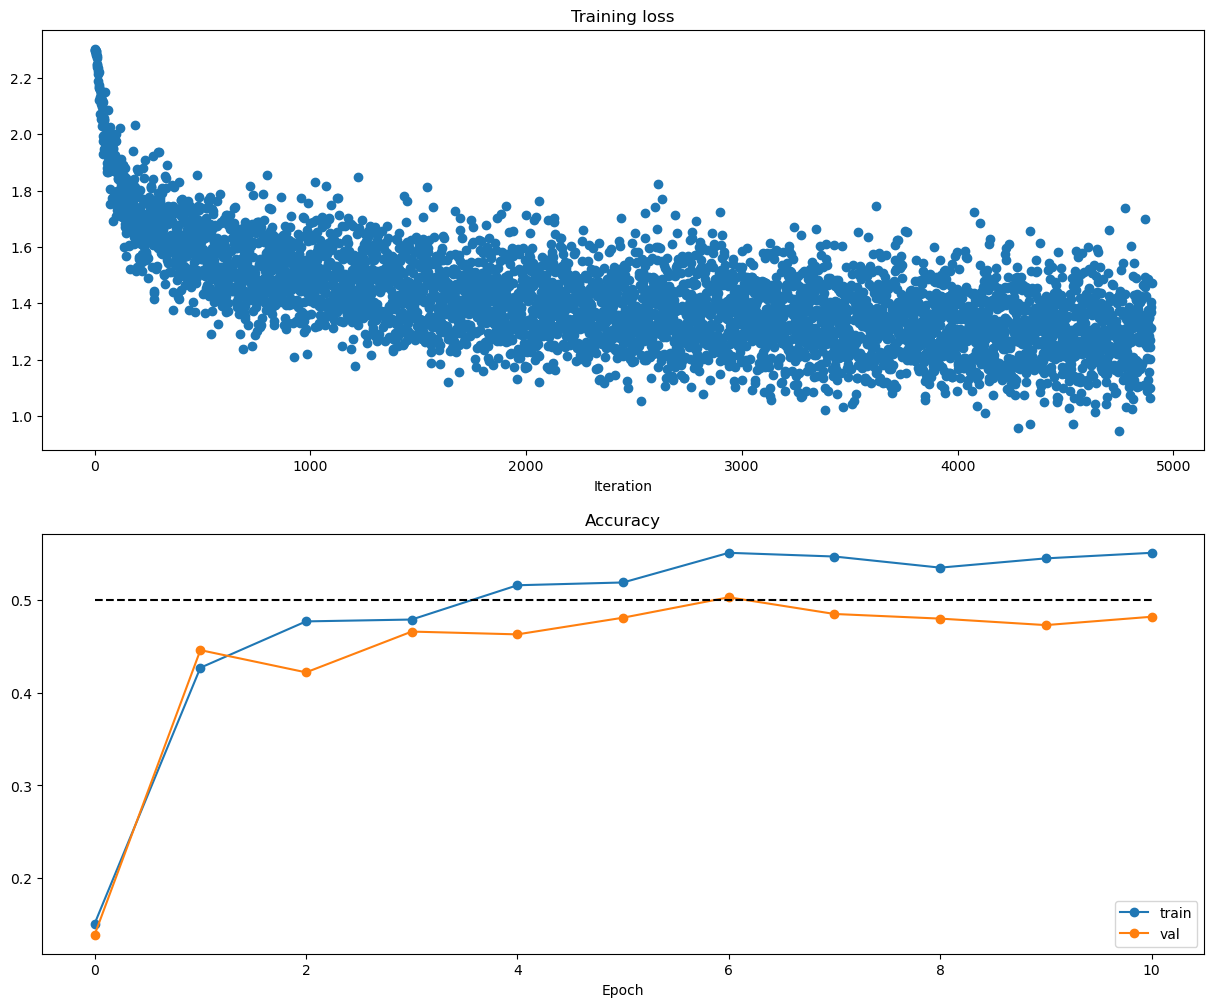

In [91]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [96]:
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.

    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid


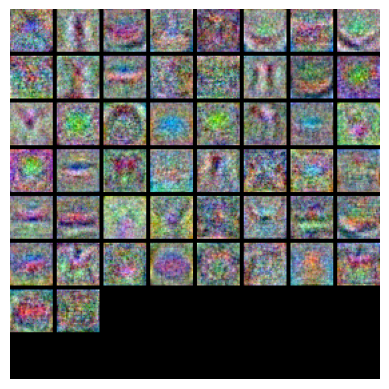

In [97]:
# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

In [107]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results = {}
best_val = -1

learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 5)

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Two Layer Net and train it with Solver
    model = TwoLayerNet(hidden_dim=128, reg=reg)
    solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=10, verbose=False)
    solver.train()
    
    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


C:\Users\DELL  LATITUDE E5480\AppData\Local\Temp\ipykernel_9588\1231642164.py:46: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(P[range(N), y]).sum() / N # sum cross entropies as loss
C:\Users\DELL  LATITUDE E5480\AppData\Local\Temp\ipykernel_9588\1231642164.py:43: RuntimeWarning: overflow encountered in subtract
  P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents
C:\Users\DELL  LATITUDE E5480\AppData\Local\Temp\ipykernel_9588\1231642164.py:43: RuntimeWarning: invalid value encountered in subtract
  P = np.exp(x - x.max(axis=1, keepdims=True)) # numerically stable exponents


lr 3.000000e-04 reg 1.000000e-06 val accuracy: 0.531000
lr 3.000000e-04 reg 1.000000e-05 val accuracy: 0.511000
lr 3.000000e-04 reg 1.000000e-04 val accuracy: 0.521000
lr 3.000000e-04 reg 1.000000e-03 val accuracy: 0.522000
lr 3.000000e-04 reg 1.000000e-02 val accuracy: 0.531000
lr 3.000000e-03 reg 1.000000e-06 val accuracy: 0.348000
lr 3.000000e-03 reg 1.000000e-05 val accuracy: 0.380000
lr 3.000000e-03 reg 1.000000e-04 val accuracy: 0.289000
lr 3.000000e-03 reg 1.000000e-03 val accuracy: 0.354000
lr 3.000000e-03 reg 1.000000e-02 val accuracy: 0.295000
lr 3.000000e-02 reg 1.000000e-06 val accuracy: 0.112000
lr 3.000000e-02 reg 1.000000e-05 val accuracy: 0.089000
lr 3.000000e-02 reg 1.000000e-04 val accuracy: 0.131000
lr 3.000000e-02 reg 1.000000e-03 val accuracy: 0.192000
lr 3.000000e-02 reg 1.000000e-02 val accuracy: 0.135000
best validation accuracy achieved during cross-validation: 0.531000


In [108]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.531


In [109]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.523
